## Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Pindah ke folder yang terdapat dataset
%cd /content/drive/MyDrive/dataset/citra_bisindo

/content/drive/MyDrive/dataset/citra_bisindo


In [3]:
!ls

A  B  C  D  E  F  G  H	I  J  K  L  M  N  O  P	Q  R  S  T  U  V  W  X	Y  Z


In [4]:
!pwd

/content/drive/MyDrive/dataset/citra_bisindo


## Import Libraries

In [5]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 15.5 MB/s eta 0:00:00


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
import shutil
import json
import tempfile
import requests
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import matplotlib.image as mpimg
from tensorflow.keras.applications import efficientnet

## Data Load

In [7]:
# Path untuk set pelatihan, validasi, dan pengujian
train_path = "/content/drive/MyDrive/dataset/train"
valid_path = "/content/drive/MyDrive/dataset/val"
test_path = "/content/drive/MyDrive/dataset/test"

# Path data asli
original_data_path = "/content/drive/MyDrive/dataset/citra_bisindo"

In [8]:
# Mendapatkan daftar folder kelas
class_folders = os.listdir(original_data_path)

In [9]:
# Memindahkan data ke folder train, test, dan val
for class_folder in class_folders:
    class_folder_path = os.path.join(original_data_path, class_folder)
    files = os.listdir(class_folder_path)
    train_files, validation_test_files = train_test_split(files, test_size=0.3, random_state=42)

    for file in train_files:
        src_path = os.path.join(class_folder_path, file)
        dst_path = os.path.join(train_path, class_folder, file)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

    validation_files, test_files = train_test_split(validation_test_files, test_size=0.5, random_state=42)

    for file in test_files:
        src_path = os.path.join(class_folder_path, file)
        dst_path = os.path.join(test_path, class_folder, file)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

    for file in validation_files:
        src_path = os.path.join(class_folder_path, file)
        dst_path = os.path.join(valid_path, class_folder, file)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

In [10]:
# Function to count files in a folder
def count_files(folder_path):
    count = sum([len(files) for root, dirs, files in os.walk(folder_path)])
    return count

# Count files in each folder
citra_files = count_files(original_data_path)
train_files = count_files(train_path)
test_files = count_files(test_path)
valid_files = count_files(valid_path)

# Print the counts
print("Number of files in 'citra':", citra_files)
print("Number of files in 'train':", train_files)
print("Number of files in 'test':", test_files)
print("Number of files in 'valid':", valid_files)

Number of files in 'citra': 2277
Number of files in 'train': 1571
Number of files in 'test': 366
Number of files in 'valid': 340


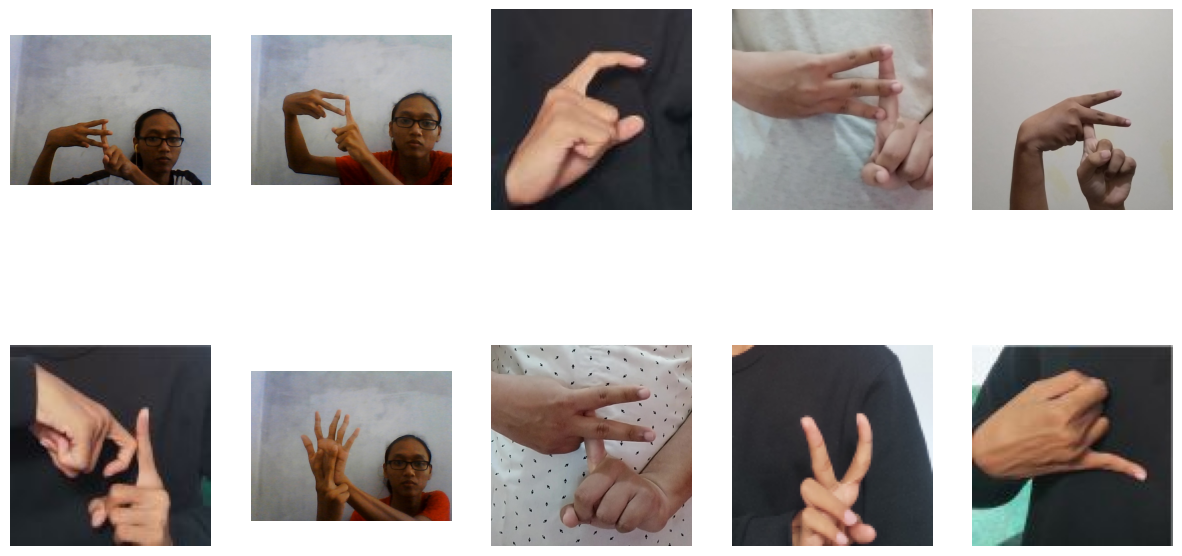

In [11]:
# Function to get a list of image files from a folder
def get_image_files(folder_path):
    image_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('jpg')):
                image_files.append(os.path.join(root, file))
    return image_files

# Get list of all image files in 'train' folder
train_image_files = get_image_files(train_path)

# Randomly select 10 image files
random_10_images = random.sample(train_image_files, 10)

# Plot the images
fig = plt.figure(figsize=(15, 8))
for i, image_path in enumerate(random_10_images, 1):
    ax = fig.add_subplot(2, 5, i)
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.axis('off')

plt.show()

## Data Pre-Processing

In [19]:
# Mendapatkan daftar folder kelas
class_folders = os.listdir(original_data_path)

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Pra-pemrosesan data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Rasio pembagian data
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

# Membuat objek generator data untuk set pelatihan
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
      # Menggunakan subset 'training' untuk set pelatihan
)

# Menghitung jumlah data untuk setiap bagian
total_samples = train_generator.samples
num_train_samples = int(total_samples * train_ratio)
num_validation_samples = int(total_samples * validation_ratio)
num_test_samples = int(total_samples * test_ratio)

# Membuat objek generator data untuk set validasi
validation_generator = train_datagen.flow_from_directory(
    valid_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
      # Menggunakan subset 'validation' untuk set validasi
)

# Membuat objek generator data untuk set pengujian
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)


Found 1571 images belonging to 26 classes.
Found 340 images belonging to 26 classes.
Found 366 images belonging to 26 classes.


In [21]:
# Menghitung jumlah data untuk setiap bagian
total_samples = train_generator.samples
num_train_samples = int(total_samples * train_ratio)
num_validation_samples = int(total_samples * validation_ratio)
num_test_samples = int(total_samples * test_ratio)

In [22]:
# Extract a batch of data from the generator
images, labels = next(test_generator)

# Print the shape of the batch of images and labels
print("Shape of images batch:", images.shape)
print("Shape of labels batch:", labels.shape)

Shape of images batch: (32, 256, 256, 3)
Shape of labels batch: (32, 26)


## Model Building

In [23]:

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Membangun arsitektur model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(26, activation='softmax'))

# Menampilkan ringkasan arsitektur model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [ ]:
# # Load pre-trained EfficientNetB1 model
# en_model = efficientnet.EfficientNetB1(weights='imagenet', include_top=False)

# # Add GlobalAveragePooling2D layer
# x = en_model.output
# x = tf.keras.layers.GlobalAveragePooling2D()(x)

# # Add Dense output layer for your classification task
# predictions = tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')(x)

# # Create the final model
# ENB1_model = tf.keras.models.Model(inputs=en_model.input, outputs=predictions)

# # Freeze all layers except for BatchNormalization layers for fine-tuning
# for layer in en_model.layers:
#     if isinstance(layer, tf.keras.layers.BatchNormalization):
#         layer.trainable = True
#     else:
#         layer.trainable = False

# # Print model summary
# ENB1_model.summary()

## Model Building

In [24]:
from keras.optimizers import Adam

# Mengompilasi model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
from keras.preprocessing.image import ImageDataGenerator

# Membuat objek ImageDataGenerator untuk augmentasi data
datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan ImageDataGenerator untuk memuat data pelatihan, validasi, dan pengujian
train_generator = datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=32, class_mode='categorical')
validation_generator = datagen.flow_from_directory(valid_path, target_size=(224, 224), batch_size=32, class_mode='categorical')
test_generator = datagen.flow_from_directory(test_path, target_size=(224, 224), batch_size=32, class_mode='categorical')

epoch = 0
max_epochs = 10
desired_accuracy = 1.0

while epoch < max_epochs:
    history = model.fit(train_generator, epochs=1, validation_data=validation_generator)
    epoch += 1

    # Mengambil akurasi pada epoch terakhir
    accuracy = history.history['accuracy'][-1]

    # Memeriksa apakah akurasi telah mencapai tingkat yang diinginkan
    if accuracy >= desired_accuracy:
        print(f"Akurasi mencapai {desired_accuracy}. Menghentikan pelatihan pada epoch ke-{epoch}.")
        break
    else:
        print(f"Akurasi pada epoch ke-{epoch}: {accuracy}. Melanjutkan pelatihan...")


Found 1571 images belonging to 26 classes.
Found 340 images belonging to 26 classes.
Found 366 images belonging to 26 classes.
50/50 [==============================] - 36s 607ms/step - loss: 3.2945 - accuracy: 0.1031 - val_loss: 2.6219 - val_accuracy: 0.3441
Akurasi pada epoch ke-1: 0.10311903059482574. Melanjutkan pelatihan...
50/50 [==============================] - 30s 596ms/step - loss: 1.5784 - accuracy: 0.5773 - val_loss: 1.5368 - val_accuracy: 0.6382
Akurasi pada epoch ke-2: 0.5773392915725708. Melanjutkan pelatihan...
50/50 [==============================] - 36s 716ms/step - loss: 0.5024 - accuracy: 0.8733 - val_loss: 0.8539 - val_accuracy: 0.8000
Akurasi pada epoch ke-3: 0.8733291029930115. Melanjutkan pelatihan...
50/50 [==============================] - 30s 605ms/step - loss: 0.1487 - accuracy: 0.9580 - val_loss: 1.0544 - val_accuracy: 0.8029
Akurasi pada epoch ke-4: 0.9579885601997375. Melanjutkan pelatihan...
50/50 [==============================] - 32s 651ms/step - loss: 

In [26]:
# Evaluasi model pada set pengujian
model.evaluate(test_generator)

12/12 [==============================] - 6s 485ms/step - loss: 1.3320 - accuracy: 0.7760


[1.3319751024246216, 0.7759562730789185]

In [27]:
MODEL_DIR = tempfile.gettempdir()

version = 1

export_path = os.path.join(MODEL_DIR, str(version))

if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

model.save(export_path, save_format="tf")

print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}


export_path = /tmp/1
total 200
drwxr-xr-x 2 root root   4096 May 27 20:43 assets
-rw-r--r-- 1 root root     56 May 27 20:43 fingerprint.pb
-rw-r--r-- 1 root root  20259 May 27 20:43 keras_metadata.pb
-rw-r--r-- 1 root root 169224 May 27 20:43 saved_model.pb
drwxr-xr-x 2 root root   4096 May 27 20:43 variables


In [28]:

!saved_model_cli show --dir {export_path} --all

2024-05-27 20:43:52.699082: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 20:43:52.699122: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 20:43:52.700364: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-27 20:43:53.686788: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the followin

In [29]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2943  100  2943    0     0   3784      0 --:--:-- --:--:-- --:--:--  3782
OK
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https

In [30]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 650 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.16.1 [650 MB]
Fetched 650 MB in 20s (32.5 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.16.1_all.deb ...
Unpacking tensorflow-model-server (2.16.1) ...
Setting up tensorflow-model-server (2.16.1) ...


In [31]:

os.environ["MODEL_DIR"] = MODEL_DIR

In [32]:

%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=digits_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [33]:

!tail server.log

[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 250] NET_LOG: Entering the event loop ...


In [34]:
test_x, test_y = test_generator.next()

In [35]:

test_x[0:3].shape

(3, 224, 224, 3)

In [36]:

data = json.dumps({"signature_name": "serving_default", "instances": test_x[0:3].tolist()})

In [37]:

headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/digits_model:predict', data=data, headers=headers)

predictions = json.loads(json_response.text)['predictions']

In [38]:
predictions

[[0.000174709989,
  4.06113088e-07,
  3.32868893e-07,
  0.999140739,
  9.35522104e-10,
  2.75802e-07,
  2.93880163e-07,
  1.08856746e-07,
  2.82848168e-06,
  4.92048287e-07,
  8.14503949e-07,
  0.00020873567,
  2.72913381e-09,
  1.73490704e-07,
  9.30121757e-07,
  4.16487092e-05,
  2.91930974e-05,
  9.20276335e-08,
  1.37940133e-05,
  5.44320683e-05,
  1.31055858e-05,
  2.51104249e-09,
  3.57083154e-05,
  0.000268940843,
  1.21380708e-05,
  2.26025421e-09],
 [7.24116908e-05,
  0.00702164881,
  0.000175039633,
  1.28128613e-05,
  0.00025586065,
  0.00038547063,
  0.000656501623,
  0.000772254309,
  0.789433658,
  0.0113411304,
  0.0801635,
  0.00141731277,
  0.000518933,
  0.0116358493,
  4.12949594e-05,
  0.0161564667,
  0.000544866314,
  0.0463999584,
  0.00119423936,
  0.012315888,
  0.000238723864,
  0.0165163409,
  0.00177508,
  0.000862820132,
  9.08324e-05,
  1.14800469e-06],
 [0.0239367411,
  0.000363872241,
  3.22047504e-06,
  0.975058317,
  3.82979026e-09,
  4.37677151e-12,
  

In [39]:
color = 'green' if np.argmax(predictions[0]) == np.argmax(test_y[0]) else 'red'
color

'green'

In [40]:
test_x[0].shape

(224, 224, 3)

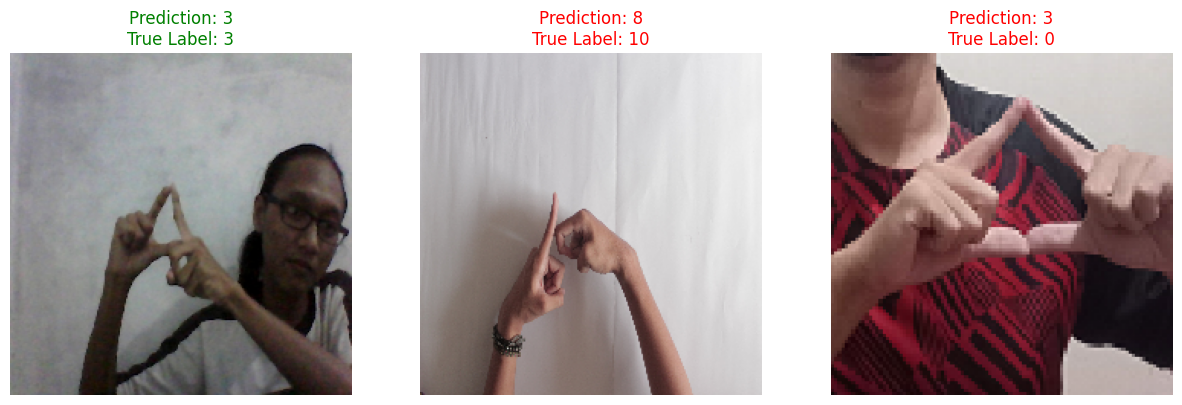

In [47]:
plt.figure(figsize=(15,15))

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(test_x[i], cmap = plt.cm.binary)
    plt.axis('off')
    color = 'green' if np.argmax(predictions[i]) == np.argmax(test_y[i]) else 'red'
    plt.title('Prediction: {}\nTrue Label: {}'.format(np.argmax(predictions[i]), np.argmax(test_y[i])), color=color)

plt.show()